In [1]:
using Turing
using DataFrames
using CSV
using Distributions
using StatsFuns
using StatsPlots
using StatsBase
using Random

default(label=false);

In [2]:
d = DataFrame(CSV.File("data/reedfrogs.csv"))
describe(d)

d.tank = 1:nrow(d)
d


Row,density,pred,size,surv,propsurv,tank
,Int64,String7,String7,Int64,Float64,Int64
1,10,no,big,9,0.9,1
2,10,no,big,10,1.0,2
3,10,no,big,7,0.7,3
4,10,no,big,10,1.0,4
5,10,no,small,9,0.9,5
6,10,no,small,9,0.9,6
7,10,no,small,10,1.0,7
8,10,no,small,9,0.9,8
9,10,pred,big,4,0.4,9


## Conventional single-level model

In [7]:
@model function frog_single_level(S, N, tank)

    a = zeros(length(tank))
    for i in 1:length(tank)
        a[i] ~ Normal(0, 1.5)
    end
    
    for i in 1:length(tank)
        p = logistic(a[i])  # probability of survival or proportional survival
        S[i] ~ Binomial(N[i], p)
    end

end

#@model function frog_single_level(S, N, tank)
#
#    a ~ filldist(Normal(0, 1.5), length(tank))  # offsets are defined for each tank
#    p = logistic.(a)  # probability of survival or proportional survival
#    S .~ Binomial.(N, p)
#
#end

frog_single_level (generic function with 2 methods)

In [14]:
Random.seed!(1)
frog_single_level_ch = sample(frog_single_level(d.surv, d.density, d.tank), NUTS(200, 0.65, init_ϵ=0.5), 1000);
frog_single_level_df = DataFrame(frog_single_level_ch)

Sampling   0%|                                          |  ETA: N/A
Sampling   0%|▎                                         |  ETA: 0:00:01
Sampling   1%|▍                                         |  ETA: 0:00:01
Sampling   2%|▋                                         |  ETA: 0:00:01
Sampling   2%|▉                                         |  ETA: 0:00:01
Sampling   2%|█                                         |  ETA: 0:00:01
Sampling   3%|█▎                                        |  ETA: 0:00:01
Sampling   4%|█▌                                        |  ETA: 0:00:01
Sampling   4%|█▋                                        |  ETA: 0:00:01
Sampling   4%|█▉                                        |  ETA: 0:00:01
Sampling   5%|██▏                                       |  ETA: 0:00:01
Sampling   6%|██▎                                       |  ETA: 0:00:01
Sampling   6%|██▌                                       |  ETA: 0:00:01
Sampling   6%|██▊                                       |  ETA: 0:00

Row,iteration,chain,a[1],a[2],a[3],a[4],a[5],a[6],a[7],a[8],a[9],a[10],a[11],a[12],a[13],a[14],a[15],a[16],a[17],a[18],a[19],a[20],a[21],a[22],a[23],a[24],a[25],a[26],a[27],a[28],a[29],a[30],a[31],a[32],a[33],a[34],a[35],a[36],a[37],a[38],a[39],a[40],a[41],a[42],a[43],a[44],a[45],a[46],a[47],a[48],lp,n_steps,is_accept,acceptance_rate,log_density,hamiltonian_energy,hamiltonian_energy_error,max_hamiltonian_energy_error,tree_depth,numerical_error,step_size,nom_step_size
,Int64,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,201,1,1.44437,3.16481,2.06368,2.91605,1.09837,2.06675,2.78773,2.42752,0.22023,1.37858,1.09501,0.988248,0.284705,0.366812,1.68811,1.86665,3.02289,2.32299,1.51569,2.57032,3.02469,2.0401,2.12407,0.559454,-1.70343,0.452535,-2.17843,-0.442093,1.06887,0.659123,-0.304081,-0.871611,3.5431,1.68913,1.65548,2.61224,2.36446,2.99865,2.15945,1.44177,-1.56574,-0.572035,-0.614858,-0.371264,0.532162,-0.806801,1.06778,0.48791,-190.858,7.0,1.0,0.964784,-190.858,227.341,-0.984041,-0.984041,3.0,0.0,0.621632,0.621632
2,202,1,1.14023,2.1703,1.06454,2.80703,0.923582,2.0855,2.87377,1.26177,-0.83465,1.20728,1.34172,1.51645,1.13692,0.897746,1.36625,2.57232,3.98632,1.71247,2.54217,3.3977,1.69617,1.73639,2.85651,0.902302,-0.938218,-0.0378742,-2.0564,-0.586505,0.177672,1.85242,-0.35029,0.340048,2.14488,2.11971,2.22769,2.20624,2.09042,4.54382,1.99502,1.76284,-1.20166,-0.118469,0.413237,-0.0884203,1.05421,-0.81403,1.25485,0.268931,-192.088,7.0,1.0,0.823662,-192.088,218.279,-0.152103,0.600231,3.0,0.0,0.621632,0.621632
3,203,1,0.553103,3.10141,0.517367,2.40412,2.17435,1.4762,3.25846,2.21727,0.00970497,2.17971,1.18153,0.10639,2.55601,-1.04115,1.05491,1.5141,3.43405,1.90078,0.710911,2.61336,2.20331,2.52218,2.41749,1.42794,-1.72088,0.227064,-1.7288,-0.792775,-0.295027,0.789355,-0.34492,-0.73001,3.26941,2.77237,1.77667,1.82057,1.53613,1.49499,1.71336,1.86694,-2.1175,-0.521178,-0.982014,0.515631,0.853215,-0.87439,1.82091,-0.139343,-193.025,7.0,1.0,0.960344,-193.025,216.504,0.2565,-0.458152,3.0,0.0,0.621632,0.621632
4,204,1,2.73543,1.75451,0.601648,1.83928,2.09297,1.08402,3.01214,1.46768,0.787447,2.41416,0.242957,0.334194,1.56075,0.848967,3.1461,1.84918,1.64303,2.75956,2.39674,3.28853,2.14309,2.43406,1.30889,1.2618,-1.05167,-0.0670943,-1.27663,-0.758328,0.310613,1.69505,-1.1473,-0.543479,2.33796,1.49632,2.67784,2.05077,2.13615,4.77802,2.65403,2.46997,-1.59296,-0.705769,-0.579294,-1.2751,0.0369425,-0.975933,1.75628,-0.199813,-187.663,7.0,1.0,1.0,-187.663,213.095,-0.605691,-0.895641,3.0,0.0,0.621632,0.621632
5,205,1,1.60537,2.35561,0.556085,2.88438,1.09661,1.54349,3.39839,0.997195,-0.235722,1.72297,1.25005,-0.0820191,0.781499,0.620975,1.66292,0.566062,2.78715,2.32959,1.28782,2.14552,3.07657,2.61504,2.67193,1.31562,-1.68762,-0.0881285,-0.981635,-0.0589777,0.0779824,1.80083,-0.595835,0.176908,2.53214,2.81992,2.46615,1.88161,1.74687,4.0296,1.85358,1.87997,-1.63911,-0.226139,-0.0917251,-0.589478,0.531033,-0.455604,2.12255,0.278235,-180.316,7.0,1.0,0.988377,-180.316,202.393,-0.560803,-0.73653,3.0,0.0,0.621632,0.621632
6,206,1,1.26145,1.85042,0.767368,3.99929,1.92228,0.299459,2.63935,0.971248,-0.440006,2.09633,1.10507,-0.977321,0.984255,-0.236223,1.8086,0.5307,2.79976,1.89963,2.14535,2.55937,1.78994,3.22465,1.27482,0.730863,-1.49347,0.0615046,-0.962347,-0.498399,-0.263392,2.35466,-0.676429,-0.609672,2.06635,2.77511,2.06393,2.22453,1.57593,2.43969,1.76815,2.46237,-1.78791,-0.283454,-0.351432,-0.276059,0.343313,-1.24511,2.05332,0.520959,-188.918,7.0,1.0,0.83129,-188.918,201.416,0.45584,0.753612,3.0,0.0,0.621632,0.621632
7,207,1

## Multilevel model

In [9]:
@model function frog_multi_level(S, N, tank)

    σ ~ Exponential()
    ā ~ Normal(0, 1.5)

    a = zeros(length(tank))  # fancier way: a = Vector{Real}(undef, length(tank))
    for i in 1:length(tank)
        a[i] ~ Normal(ā, σ)
    end
    
    for i in 1:length(tank)
        p = logistic(a[i])  # probability of survival or proportional survival
        S[i] ~ Binomial(N[i], p)
    end

end


# @model function frog_multi_level(S, N, tank)

#     σ ~ Exponential()
#     ā ~ Normal(0, 1.5)

#     a ~ filldist(Normal(ā, σ), length(tank))
#     p = logistic.(a)
#     S .~ Binomial.(N, p)

# end

frog_multi_level (generic function with 2 methods)

In [10]:
Random.seed!(1)
frog_multi_level_ch = sample(frog_multi_level(d.surv, d.density, d.tank), NUTS(200, 0.65, init_ϵ=0.2), 1000)
frog_multi_level_df = DataFrame(frog_multi_level_ch);

Sampling   0%|                                          |  ETA: N/A
Sampling   0%|▎                                         |  ETA: 0:13:22
Sampling   1%|▍                                         |  ETA: 0:06:41
Sampling   2%|▋                                         |  ETA: 0:04:27
Sampling   2%|▉                                         |  ETA: 0:03:21
Sampling   2%|█                                         |  ETA: 0:02:40
Sampling   3%|█▎                                        |  ETA: 0:02:13
Sampling   4%|█▌                                        |  ETA: 0:01:54
Sampling   4%|█▋                                        |  ETA: 0:01:40
Sampling   4%|█▉                                        |  ETA: 0:01:29
Sampling   5%|██▏                                       |  ETA: 0:01:20
Sampling   6%|██▎                                       |  ETA: 0:01:12
Sampling   6%|██▌                                       |  ETA: 0:01:06
Sampling   6%|██▊                                       |  ETA: 0:01

In [19]:
single_level_surival = zeros(nrow(frog_single_level_df), nrow(d));

for j in 1:nrow(frog_single_level_df)
    for i in 1:nrow(d)
        tank_id = d.tank[i]
        tank_density = d.density[i]
        tank_surv = d.surv[i]  
        single_level_surival[j,i] = binomlogpdf(tank_density, logistic(frog_single_level_df[j,"a[$(tank_id)]"]), tank_surv)
    end
end

single_level_surival

1000×48 Matrix{Float64}:
 -1.25974   -0.41355   -2.59901  -0.527323  …  -2.05423  -3.74701  -3.29978
 -1.61204   -1.08085   -1.36922  -0.586313     -2.0631   -2.93328  -2.47443
 -2.7941    -0.440034  -1.44017  -0.864944     -2.15224  -1.66907  -2.0397
 -1.06134   -1.59558   -1.3865   -1.47499      -2.36161  -1.73462  -2.09897
 -1.13279   -0.90604   -1.41347  -0.543834     -2.11244  -1.58224  -2.50121
 -1.45277   -1.45978   -1.32793  -0.181627  …  -3.25475  -1.57256  -3.45915
 -1.62059   -1.86254   -1.58287  -0.632702     -1.99954  -1.62833  -2.01026
 -1.32016   -1.25589   -1.38564  -2.1277       -2.03308  -1.61178  -3.72353
 -1.43113   -1.29187   -1.65356  -1.008        -2.28011  -1.59422  -3.41168
 -1.29949   -1.28922   -1.32131  -1.58427      -1.99368  -1.63743  -4.37705
  ⋮                                         ⋱   ⋮                  
 -0.976125  -1.21076   -2.11728  -1.08281      -2.95819  -1.91121  -2.07025
 -1.09153   -0.874467  -2.23082  -1.12337      -2.951    -3.07935  -2.15

In [21]:
multi_level_survival = zeros(nrow(frog_multi_level_df), nrow(d));

for j in 1:nrow(frog_multi_level_df)
    for i in 1:nrow(d)
        tank_id = d.tank[i]
        tank_density = d.density[i]
        tank_surv = d.surv[i]  
        multi_level_survival[j,i] = binomlogpdf(tank_density, logistic(frog_multi_level_df[j,"a[$(tank_id)]"]), tank_surv)
    end
end

multi_level_survival

1000×48 Matrix{Float64}:
 -0.981011  -0.202083   -1.39545  -0.178837   …  -2.86085  -1.73127  -2.60562
 -0.949407  -1.4197     -1.46033  -1.14338       -2.25439  -1.82659  -2.59208
 -0.960947  -0.517037   -1.42723  -0.150774      -2.84311  -1.57639  -2.71776
 -0.953671  -0.357843   -2.01619  -0.737768      -4.24179  -1.57262  -3.59612
 -0.968567  -0.0225708  -1.50105  -0.516013      -3.54127  -1.67344  -3.01391
 -1.0742    -1.23991    -1.36359  -0.236195   …  -1.96149  -1.60713  -2.49417
 -0.956275  -0.222531   -1.41859  -1.2385        -1.96664  -1.89871  -2.0428
 -1.0153    -0.191627   -1.67074  -0.455824      -2.19095  -1.58202  -2.20937
 -0.994734  -0.542307   -2.27682  -0.805286      -1.97985  -2.12977  -2.36921
 -1.07123   -0.478051   -1.35606  -0.341969      -2.83676  -2.90235  -2.28353
  ⋮                                           ⋱   ⋮                  
 -0.952007  -0.442605   -2.73961  -3.35489       -1.99801  -1.59679  -3.13613
 -1.03221   -0.207612   -3.45617  -2.27717      

In [23]:
## a "fancier" and more compact way

# link_fun = (chain_df, dr) -> begin
#     a = chain_df[:,"a[$(dr.tank)]"]
#     p = logistic.(a)
#     binomlogpdf.(dr.density, p, dr.surv)
# end

# single_level_survival = map( dr -> link_fun(frog_single_level_df, dr), eachrow(d) )
# single_level_survival = hcat(single_level_survival...)

# multi_level_survival = map( dr -> link_fun(frog_multi_level_df, dr), eachrow(d) )
# multi_level_survival = hcat(multi_level_survival...);


In [30]:
# sample 10_000 samples again from the multi-level model

post = sample(frog_multi_level_ch, 10000)
post_df = DataFrame(post)


Row,iteration,chain,σ,ā,a[1],a[2],a[3],a[4],a[5],a[6],a[7],a[8],a[9],a[10],a[11],a[12],a[13],a[14],a[15],a[16],a[17],a[18],a[19],a[20],a[21],a[22],a[23],a[24],a[25],a[26],a[27],a[28],a[29],a[30],a[31],a[32],a[33],a[34],a[35],a[36],a[37],a[38],a[39],a[40],a[41],a[42],a[43],a[44],a[45],a[46],a[47],a[48],lp,n_steps,is_accept,acceptance_rate,log_density,hamiltonian_energy,hamiltonian_energy_error,max_hamiltonian_energy_error,tree_depth,numerical_error,step_size,nom_step_size
,Int64,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,1,1,1.43387,0.771309,2.16026,3.00193,0.807725,4.38401,1.33442,1.95317,3.05689,1.84638,0.705402,2.38525,0.433173,0.741646,0.669546,-0.113525,1.96865,1.43387,2.78781,1.62569,2.37032,1.87093,1.74987,2.28532,1.39044,1.59084,-0.761884,-0.47646,-2.02319,-0.680856,-0.685793,1.27655,-0.372325,-0.156694,3.73576,1.85515,3.08598,2.07329,1.61873,3.38321,1.89869,1.04431,-2.75853,-0.441824,-0.447119,-0.480523,0.38614,0.145538,1.17076,0.497779,-180.805,7.0,1.0,0.600395,-180.805,200.517,0.849015,1.09756,3.0,0.0,0.600791,0.600791
2,2,1,1.87638,1.18684,2.59991,1.77441,0.529502,5.22961,1.91643,2.06006,2.11203,1.13011,0.594778,1.47068,0.810708,-1.17264,0.321713,-0.521478,2.81564,1.21213,5.05875,4.16215,2.98011,2.94407,2.28633,2.71663,2.87616,1.35528,-0.41537,0.579673,-2.88602,-1.13273,-0.793432,2.47329,-1.06414,-0.250149,3.78164,3.98828,3.02747,1.95709,2.01548,3.68499,2.56473,2.8193,-2.02003,-0.940168,-0.531976,0.295442,0.319758,-0.948179,2.48086,-0.259069,-192.998,7.0,1.0,0.719461,-192.998,217.887,0.59236,1.00783,3.0,0.0,0.600791,0.600791
3,3,1,1.67714,1.42442,1.89427,3.10434,0.727983,4.34733,1.76949,3.22344,2.2412,2.2921,0.185371,2.62953,1.02172,1.02325,1.21884,0.277008,2.716,2.77952,3.3635,2.22684,2.39341,3.64983,3.04886,1.92401,2.17064,1.63805,-1.08159,-0.430016,-1.42718,-0.884013,-0.17852,1.19648,-0.0085148,-0.578531,3.60626,2.51209,2.53687,2.16478,2.13939,4.41084,2.50931,3.15756,-1.2761,-0.468512,-0.513087,0.00354248,0.0591701,-0.454796,2.18839,0.434667,-168.552,7.0,1.0,0.788252,-168.552,186.543,0.0276587,0.631641,3.0,0.0,0.600791,0.600791
4,4,1,1.59725,1.5246,1.43086,3.46721,1.35134,5.29524,3.28007,1.95319,3.02313,2.72759,-0.527884,1.66619,1.42205,-0.0264016,0.198239,0.24036,3.28698,1.72012,1.54263,1.92118,2.33522,3.78546,2.48375,1.9741,1.55422,1.56292,-1.26332,0.11252,-1.67088,-0.651085,0.143268,1.59339,-0.545916,-0.927869,3.16959,2.29301,2.28333,2.9679,0.987133,4.38568,2.72677,2.39275,-1.54823,-0.461797,-0.948555,-0.431199,0.737109,-1.09314,2.65925,0.185855,-174.834,7.0,1.0,0.96251,-174.834,198.137,-0.336418,-0.732867,3.0,0.0,0.600791,0.600791
5,5,1,1.41437,1.12641,1.10426,1.52195,0.762413,3.25377,1.7567,1.34582,2.47963,2.75056,0.293534,1.56999,0.504012,0.566501,0.621521,-0.594008,1.13385,2.0863,2.60269,1.95148,3.00777,2.79928,2.29587,2.25977,2.4537,1.2713,-1.29723,0.345753,-1.23705,-0.367132,-0.0734804,1.14881,-0.805127,-0.0372609,3.76899,3.50484,3.643,2.30199,3.17635,3.3614,2.38669,1.61372,-0.936236,-0.789156,-0.291409,-0.57903,0.392844,-0.533969,1.31086,0.260374,-171.563,7.0,1.0,0.728213,-171.563,204.87,-0.57501,-0.57501,3.0,0.0,0.600791,0.600791
6,6,1,1.88647,1.56438,2.53329,2.88727,1.8825,2.47861,1.6468,1.43223,5.36333,1.868,0.204531,1.18667,2.36438,1.61203,1.34803,-0.80945,1.40809,3.09098,3.59596,1.46574,2.40548,3.2981,3.26416,1.5659,1.17597,1.45123,-1.25577,0.211463,-2.15859,-0.697287,0.649787,1.65977,-0.351147,-0.434844,2.53465,2.77491,3.57213,1.9668,2.14133,2.47747,2.14412,2.87047,-1.94669,-0.366963,-0.219412,-0.36025,0.858695,-0.722434,1.52314,0.229517,-180.34

In [31]:
propsurv_est = [                # array comprehension
    logistic(mean(post_df[:,"a[$i]"]))
    for i ∈ 1:nrow(d)
]

48-element Vector{Float64}:
 0.8972965142422652
 0.9568109710697195
 0.732544459958648
 0.9529223890809224
 0.8975814232383746
 0.8916243588497255
 0.9531003060292864
 0.8936132446535103
 0.4585320523067667
 0.8961163200591507
 ⋮
 0.9103832844309806
 0.140473114345525
 0.35956420453617366
 0.39119331869172125
 0.41613714096376625
 0.6395878263865165
 0.3627318785270039
 0.8855466287963164
 0.5005689503927557

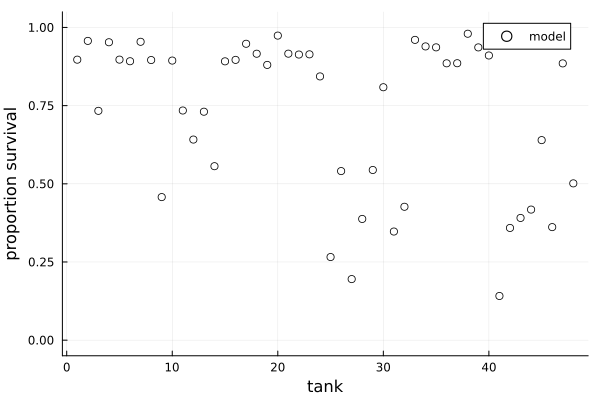

In [26]:
scatter(propsurv_est, mc=:white, label="model", legend=:topright, xlab="tank", ylab="proportion survival", ylim=(-0.05, 1.05))


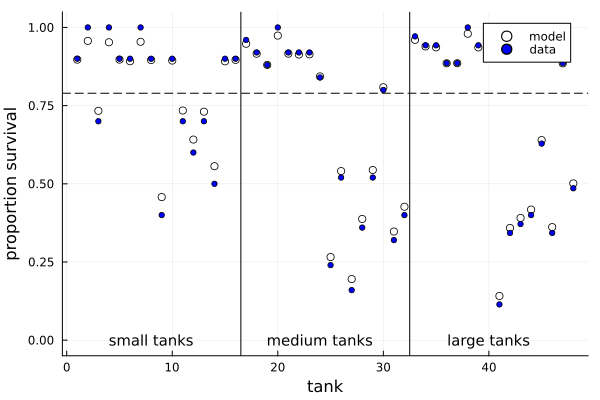

In [27]:
scatter!(d.propsurv, mc=:blue, ms=3, label="data")
hline!([mean(logistic.(post_df.ā))], ls=:dash, c=:black)
vline!([16.5, 32.5], c=:black)
annotate!([
        (8, 0, ("small tanks", 10)),
        (16+8, 0, ("medium tanks", 10)),
        (32+8, 0, ("large tanks", 10))
])


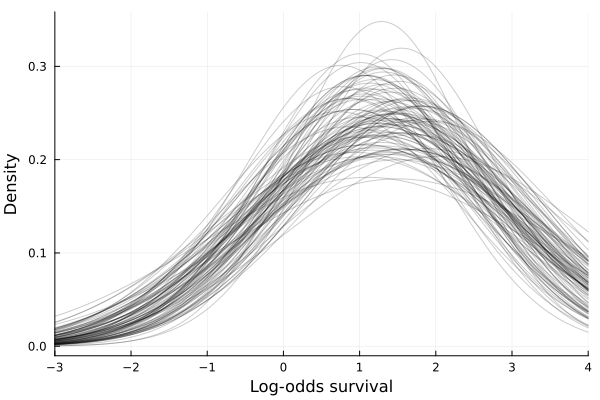

In [33]:
p1 = plot(xlim=(-3, 4), xlab="Log-odds survival", ylab="Density");

for j in 1:100  # first 100 rows (or samples)
    plot!(Normal(post_df.ā[j], post_df.σ[j]), c=:black, alpha=0.2)
end

## a fancier way
# for r ∈ first(eachrow(post_df), 100)
#     plot!(Normal(r.ā, r.σ), c=:black, alpha=0.2)
# end

p1


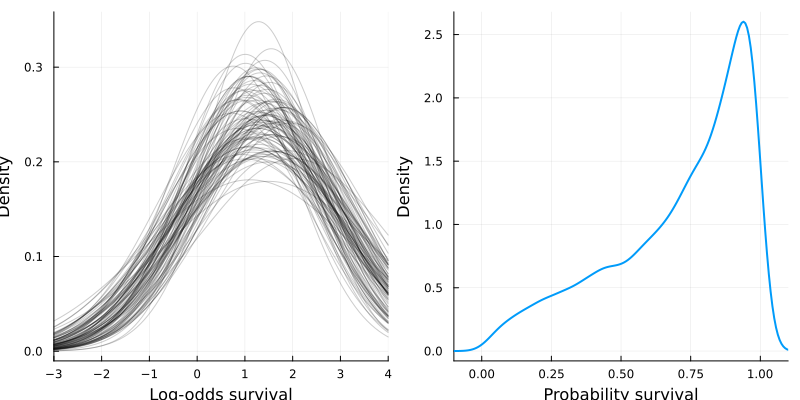

In [34]:
p2 = plot(xlab="Probability survival", ylab="Density", xlim=(-0.1, 1.1));

sim_tanks_logistic = zeros(8000)
for j in 1:8000  # 8000 rows (or samples)
    sim_tanks_logistic[j] = logistic( rand( Normal(post_df.ā[j], post_df.σ[j]) ) )
end
density!(sim_tanks_logistic, lw=2)

# a more compact code using broadcasting
#sim_tanks = rand.(Normal.(post_df.ā[1:8000], post_df.σ[1:8000]));  # we could have used for loops
#density!(logistic.(sim_tanks), lw=2)

plot(p1, p2, size=(800, 400))


In [35]:
## Varying effects and the underfitting/overfitting trade-off
# Generate a mock data to test the models

ā = 1.5
σ = 1.5
nponds = 60
Ni = repeat([3, 10, 25, 35], inner=15);

a_pond = rand(Normal(ā, σ), nponds);    # mock "true" data

dsim = DataFrame(pond=1:nponds, Ni=Ni, true_a=a_pond)


Row,pond,Ni,true_a
,Int64,Int64,Float64
1,1,3,1.07492
2,2,3,-0.291018
3,3,3,0.807494
4,4,3,2.40729
5,5,3,0.959518
6,6,3,2.90325
7,7,3,3.09217
8,8,3,-0.38519
9,9,3,1.85108


In [37]:
dsim.p_true = logistic.(dsim.true_a);

Random.seed!(1)
dsim.Si = rand.(Binomial.(dsim.Ni, dsim.p_true));

In [38]:
# no pooling (treat each pond separately)
dsim.p_nopool = dsim.Si ./ dsim.Ni;


In [41]:
# partial pooling using the multi-level model
@model function pond_multi_level(Si, Ni) #, pond)

    σ ~ Exponential()
    ā ~ Normal(0, 1.5)

    a_pond = zeros(length(Ni))  # fancier way: a = Vector{Real}(undef, length(tank))
    for i in 1:length(Ni)
        a_pond[i] ~ Normal(ā, σ)
    end
    
    for i in 1:length(Ni)
        p = logistic(a_pond[i])  # probability of survival or proportional survival
        Si[i] ~ Binomial(Ni[i], p)
    end

    # # a more compact way
    # a_pond ~ filldist(Normal(ā, σ), length(Ni))
    # p = logistic.(a_pond)
    # @. Si ~ Binomial(Ni, p)

end

pond_multi_level (generic function with 2 methods)

In [42]:
Random.seed!(1)
pond_multi_level_ch = sample(pond_multi_level(dsim.Si, dsim.Ni), NUTS(), 1000)
pond_multi_level_df = DataFrame(pond_multi_level_ch);


Sampling   0%|                                          |  ETA: N/A
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /Users/stju/.julia/packages/Turing/0yJdp/src/mcmc/hmc.jl:191
Sampling   0%|▎                                         |  ETA: 0:12:50
Sampling   1%|▍                                         |  ETA: 0:06:31
Sampling   1%|▋                                         |  ETA: 0:04:24
Sampling   2%|▊                                         |  ETA: 0:03:21
Sampling   2%|█                                         |  ETA: 0:02:42
Sampling   3%|█▏                                        |  ETA: 0:02:16
Sampling   3%|█▍                                        |  ETA: 0:01:57
Sampling   4%|█▋                                        |  ETA: 0:01:43
Sampling   4%|█▊                                        |  ETA: 0:01:32
Sampling   5%|██                                        |  ETA: 0:01:23
Sampling   5%|██▏                                       |  ETA: 0:01:16
Sampling   6%|

In [43]:
dsim.p_partpool = [
    mean(logistic.(pond_multi_level_df[:,"a_pond[$i]"]))
    for i ∈ 1:nponds
];

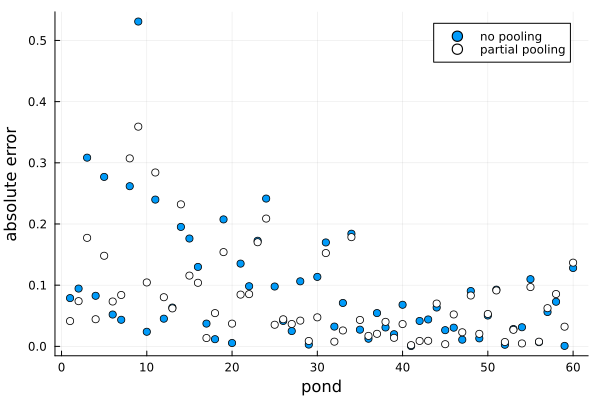

In [44]:
nopool_error = abs.(dsim.p_nopool - dsim.p_true)
partpool_error = abs.(dsim.p_partpool - dsim.p_true);

plt = scatter(nopool_error, xlab="pond", ylab="absolute error", label = "no pooling")
scatter!(partpool_error, mc=:white, label = "partial pooling")

In [45]:
dsim.nopool_error = nopool_error
dsim.partpool_error = partpool_error

60-element Vector{Float64}:
 0.04131085644330401
 0.07386414374659289
 0.1773444092332197
 0.04432021415072718
 0.1480439216644961
 0.07329257617143303
 0.08394781336979518
 0.30725747200178055
 0.3591091072599216
 0.10443226005508222
 ⋮
 0.007064804197787877
 0.027022885835333077
 0.004749070825003088
 0.09689659937113593
 0.0076011299478574434
 0.062378600767184156
 0.0855186130150482
 0.03213112969800716
 0.13679956679147232

In [49]:
dsim

Row,pond,Ni,true_a,p_true,Si,p_nopool,p_partpool,nopool_error,partpool_error
,Int64,Int64,Float64,Float64,Int64,Float64,Float64,Float64,Float64
1,1,3,1.07492,0.745531,2,0.666667,0.70422,0.0788643,0.0413109
2,2,3,-0.291018,0.427755,1,0.333333,0.501619,0.0944213,0.0738641
3,3,3,0.807494,0.691575,3,1.0,0.86892,0.308425,0.177344
4,4,3,2.40729,0.917381,3,1.0,0.873061,0.0826188,0.0443202
5,5,3,0.959518,0.723025,3,1.0,0.871069,0.276975,0.148044
6,6,3,2.90325,0.948007,3,1.0,0.874714,0.0519933,0.0732926
7,7,3,3.09217,0.956569,3,1.0,0.872621,0.0434314,0.0839478
8,8,3,-0.38519,0.404876,2,0.666667,0.712133,0.261791,0.307257
9,9,3,1.85108,0.864254,1,0.333333,0.505145,0.53092,0.359109


In [48]:
# group results according to the number of tadpoles
gb = groupby(dsim, :Ni)

Row,pond,Ni,true_a,p_true,Si,p_nopool,p_partpool,nopool_error,partpool_error
,Int64,Int64,Float64,Float64,Int64,Float64,Float64,Float64,Float64
1,1,3,1.07492,0.745531,2,0.666667,0.70422,0.0788643,0.0413109
2,2,3,-0.291018,0.427755,1,0.333333,0.501619,0.0944213,0.0738641
3,3,3,0.807494,0.691575,3,1.0,0.86892,0.308425,0.177344
4,4,3,2.40729,0.917381,3,1.0,0.873061,0.0826188,0.0443202
5,5,3,0.959518,0.723025,3,1.0,0.871069,0.276975,0.148044
6,6,3,2.90325,0.948007,3,1.0,0.874714,0.0519933,0.0732926
7,7,3,3.09217,0.956569,3,1.0,0.872621,0.0434314,0.0839478
8,8,3,-0.38519,0.404876,2,0.666667,0.712133,0.261791,0.307257
9,9,3,1.85108,0.864254,1,0.333333,0.505145,0.53092,0.359109


In [50]:
pools = combine(gb, :nopool_error => mean, :partpool_error => mean, :pond => minimum, :pond => maximum)

Row,Ni,nopool_error_mean,partpool_error_mean,pond_minimum,pond_maximum
,Int64,Float64,Float64,Int64,Int64
1,3,0.164878,0.145812,1,15
2,10,0.0950877,0.0750749,16,30
3,25,0.0563798,0.0419289,31,45
4,35,0.0483,0.0522041,46,60


In [54]:
pools.pond_minimum, pools.pond_maximum # ranges of pond numbers with the same numbers of tadpoles


([1, 16, 31, 46], [15, 30, 45, 60])

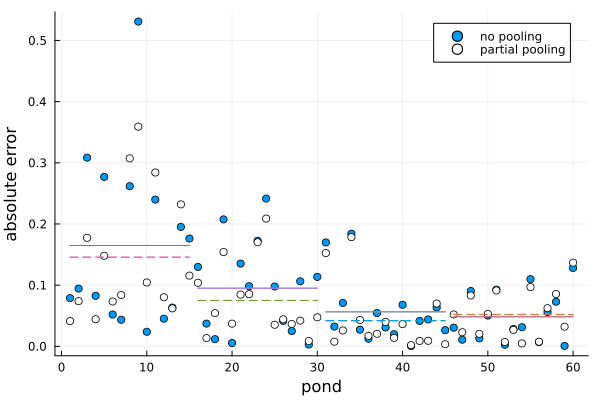

In [52]:
for i in 1:length(pond_min)
    plot!([pools.pond_minimum[i],pools.pond_maximum[i]],[pools.nopool_error_mean[i],pools.nopool_error_mean[i]])
end

for i in 1:length(pond_min)
    plot!([pools.pond_minimum[i],pools.pond_maximum[i]],[partpool_mean[i],partpool_mean[i]], line=:dash)
end

plt